In [2]:
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import math
from scipy.stats import expon  #per fit esponenziale autocorrelazione
from scipy.optimize import curve_fit
import scipy
import time, sys


#### Esercizi svolti da Stefano Polo

#### Matricola: 940175

#### Informazione sulla cartella contenente codici e risultati di "Exercise 07.4":
La struttura della cartella è funzionale per una compilazione semplice del *notebook*. Infatti tutti i risultati delle simulazioni sono disposti nella cartella <span style="color:red"> Risultati </span> catalogati in base all'algoritmo adottato (Metropolis per NVT e Verlet per NVE) e alla fase simulata (fase gassosa, liquida e solida). Di conseguenza al fine della compilazione del *notebook* non è necessario rieseguire le simulazioni. Nella cartella <span style="color:red">Codici</span> sono catalogati tutti i codici C++ delle simulazioni con il Metropolis (NVT) e con il Verlet (NVE). La compilazione e l'esecuzione di quest'ultimi prevede l'automatica sovrascrittura dei file contenenti i risultati su quelli vecchi contenuti nella cartella <span style="color:red"> Risultati</span> (dunque un'esecuzione dei codici non richiede che i nuovi risultati vengano copiati a mano in <span style="color:red"> Risultati</span>). Per compilare e eseguire i codici è consigliabile eseguire il comando da terminale <span style="color:green">make esegui</span> (infatti automaticamente vengono eliminati i vecchi risultati con lo script "clean.sh"; operazione necessaria dal momento che la scrittura su file delle simulazioni sfrutta la modalità "ios::app"). 
Se invece si volesse compilare e eseguire tutte e tre le simulazioni (relative a fase solida, liquida e gassosa) è disponibile (sia in <span style="color:red"> NVE_Verlet</span> sia in <span style="color:red"> Metropolis_NVT</span>) uno "script.sh" che esegue tutto in automatico.

# <span style="color:green"> Numerical Simulation Laboratory (NSL) </span>
## <span style="color:blue">  Numerical exercises 7</span>


#### Informazioni generali sulla simulazione Monte Carlo del sistema NVT
Negli esercizi svolti per questa esercitazione è richiesta di svolgere una simulazione del sistema canonico NVT (108 particelle in una box cubica con condizioni periodiche al contorno) attraverso l'algoritmo di Metropolis campionando il peso di Boltzmann $p(\{ s_i \}) = \exp(-\beta H)/Z$ ($Z$ è la funzione di partizione). Ho adottato le seguenti condizioni termodinamiche (le grandezze indicate con l'apice $\star$ sono espresse in unità ridotte di Lennard Jones):
- fase solida: $\rho^\star = 1.1$, $T^\star = 0.8$ (raggio di cut-off: $r_c^\star = 2.2$)
- fase liquida: $\rho^\star = 0.8$, $T^\star = 1.1$ (raggio di cut-off: $r_c^\star = 2.5$)
- fase gassosa: $\rho^\star = 0.05$, $T^\star = 1.2$ (raggio di cut-off: $r_c^\star = 5.0$)

Prima di eseguire ciascuna simulazione, ho imposto su tutti i sistemi una fase di equilibrazione per un certo numero di passi del Metropolis $N_{eq}$. Inoltre il passo $a^\star$ dell'algoritmo è stato fissato in modo tale da avere $\sim 50\%$ di *acceptance ratio*. Nella tabella sottostante riporto i parametri adottati per ciascuna fase:

Parametro |Fase solida | Fase liquida | Fase gassosa
-------|--------|--------|--------|--------|----
$N_{eq} $|$5\times10^3$ |$5\times10^3$|$5\times10^3$
$a^\star$|0.11|0.199|6.00|

Il parametro $N_eq$ è stato scelto osservando l'andamento dei valori istantanei della pressione $P$ e dell'energia potenziale per particella $U/N$, in modo tale che questi non presentassero fluttuazioni anomale nel corso della simulazione.

Il passo $a^\star$ fissato per la fase gassosa ha permesso di ottenere un *acceptance ratio* di $\sim 60\%$ (sotto non era possibile scendere a causa delle condizioni periodiche al contorno).

Finita la fase di equilibrazione l'algoritmo è stato eseguito per un numero di passi $M = 10^5$ per un numero di blocchi $N_{block} = 100$.

### Exercise 07.1

1. Calcolare la funzione di autocorrelazione $Ac(\tau)$ per l'energia potenziale per particella $U/N$ e della pressione $P$ per ciascuna simulazione NVT (fase solida, liquida e gassosa) e ottenere il tempo Monte Carlo di correlazione $\tau_c$ da un suo fit con una curva esponenziale.

Per risolvere questo esercizio ho implementato nel mio codice C++ un metodo che fosse in grado di stampare su file i valori istantanei per $P$ e $U/N$ (metodo <span style="color:green">Print_Istant()</span>). Nella cella sottostante leggo da file tali valori per il calcolo di $Ac(\tau)$.

In [3]:
#Fase solida
epot_ist_solid = np.loadtxt('Risultati/NVT_Metropolis/Solid/istant.epot.0', usecols=(0),unpack='true')
pres_ist_solid = np.loadtxt('Risultati/NVT_Metropolis/Solid/istant.pres.0', usecols=(0),unpack='true')
#Fase liquida
epot_ist_liquid = np.loadtxt('Risultati/NVT_Metropolis/Liquid/istant.epot.0', usecols=(0),unpack='true')
pres_ist_liquid = np.loadtxt('Risultati/NVT_Metropolis/Liquid/istant.pres.0', usecols=(0),unpack='true')
#Fase gassosa
epot_ist_gas = np.loadtxt('Risultati/NVT_Metropolis/Gas/istant.epot.0', usecols=(0),unpack='true')
pres_ist_gas = np.loadtxt('Risultati/NVT_Metropolis/Gas/istant.pres.0', usecols=(0),unpack='true')

Nella cella sottostante implemento (funzione <span style="color:green">Auto_corr(x,t)</span>) il calcolo della funzione di autocorrelazione secondo la relazione:

$$
Ac(\tau) = \frac{\frac{1}{t-\tau}\sum_{t' = 0}^{t-\tau}x(t')x(t'+\tau)-\frac{1}{t-\tau}\sum_{t' = 0}^{t-\tau}x(t')\times \frac{1}{t-\tau}\sum_{t' = 0}^{t-\tau}x(t'+\tau)}{\frac{1}{t}\sum_{t' = 0}^{t}x^2(t')-\left(\frac{1}{t}\sum_{t' = 0}^{t}x(t')\right)^2} \, ,
$$

dove $x(t)$ è il valore di $P$ o $U/N$ al tempo Monte Carlo $t$ (tempo discreto).

In [4]:
def Auto_corr(x,t): #t corrisponde a tau nella formula sopra e x sono i dati di input (pressione o energia)
    t_max=len(x)  #t_max corrisponde a t nella formula sopra
    norm=(1./(t_max-t))
    x_old=x[0:t_max-t]
    x_new=x[t:]
    
    num= norm*np.sum(x_old*x_new)-(norm**2)*np.sum(x_old)*np.sum(x_new)
    den=(1./t_max)*np.sum(x**2)- ((1./t_max)*np.sum(x))**2
    return num/den

Nella cella sottostante calcolo con la funzione appena implementata le autocorrelazioni per tutte e tre le fasi.

In [5]:
n_dati=len(pres_ist_solid)
n_punti=int(n_dati/100)

correlation_pres_solid=np.zeros(n_punti)
correlation_epot_solid=np.zeros(n_punti)
correlation_pres_liquid=np.zeros(n_punti)
correlation_epot_liquid=np.zeros(n_punti)
correlation_pres_gas=np.zeros(n_punti)
correlation_epot_gas=np.zeros(n_punti)

for t in range(n_punti):
    correlation_pres_solid[t]=Auto_corr(pres_ist_solid,t)
    correlation_epot_solid[t]=Auto_corr(epot_ist_solid,t)
    correlation_pres_liquid[t]=Auto_corr(pres_ist_liquid,t)
    correlation_epot_liquid[t]=Auto_corr(epot_ist_liquid,t)
    correlation_pres_gas[t]=Auto_corr(pres_ist_gas,t)
    correlation_epot_gas[t]=Auto_corr(epot_ist_gas,t)

Nella cella sottostante presento, per tutte le tre fasi, le funzioni di autocorrelazione $Ac(\tau)_P$ e $Ac(\tau)_U$ rispettivamente di pressione e energia potenziale per particella. Inoltre tali curve sono state sottospote a un fit con una curva esponenziale 

$$ y(\tau) = e^{-\tau/\tau_c} \, .$$ 

I grafici sono presentati in scala bilogaritmica.

Ho imposto al fit che $y(0) =1 $, per definizione di curva di autocorrelazione (per questo motivo la cella presenta un errore in arancione; ciò però non compromette la compilazione della cella).
Inoltre, per ottenere un buon risultato nel fit, i dati sono stati tagliati, poiché $Ac(\tau)$ presenta valori oscillanti per $\tau$ grandi.

Riporto nella tabella sottostane i risultati dei tempi di correlazione ottenuti $\tau_c$ ottenuti dai fit:

Parametro fit |Fase solida | Fase liquida | Fase gassosa
-------|--------|--------|--------|--------|----
Pressione: $\tau_c$|8.1 |13.2|0.87
Energia potenziale: $\tau_c$|8.2|10.2|2.56|

Si osserva come per il solido $P$ e $U/N$ presentino pressoché un medesimo $\tau_c$, mentre non vale lo stesso per gas e liquido. Questo potrebbe essere spiegato dal fatto che il fit eseguito con una curva esponenziale non sia un buon fit per $Ac(\tau)_P$ e $Ac(\tau)_U$. Tuttavia questi risultati possono essere utili per farsi un'idea su quanto prendere larghi i blocchi di dati per il metodo del *data blocking* (almeno $2\tau_c$).   

/home/ste/anaconda3/lib/python3.6/site-packages/scipy/optimize/minpack.py:794: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


FASE SOLIDA: Tempo di correlazione Presssione:  8.135359489468849
FASE SOLIDA: Tempo di correlazione Energia Potenziale:  8.25801171575045

FASE LIQUIDA: Tempo di correlazione Presssione:  13.20255041238391
FASE LIQUIDA: Tempo di correlazione Energia Potenziale:  10.178458587564803

FASE GASSOSA: Tempo di correlazione Presssione:  0.8864214878016061
FASE GASSOSA: Tempo di correlazione Energia Potenziale:  2.610613697417937


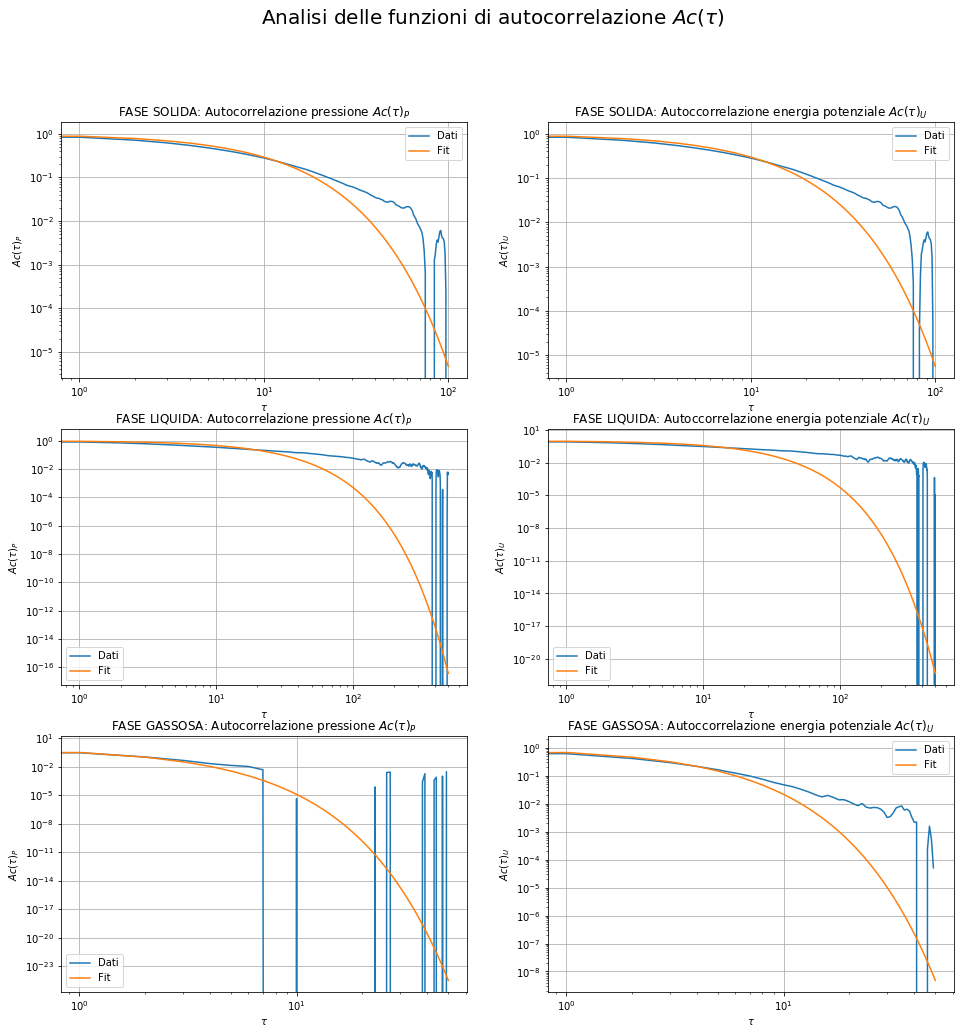

In [6]:
plt.figure(figsize=(16,16))
plt.suptitle(r'Analisi delle funzioni di autocorrelazione $Ac(\tau)$',fontsize=20)

#FASE SOLIDA PLOTS E FIT
n_cut = 100 #fino dove tagliare i dati
t=np.linspace(0,n_cut, n_cut)
correlation_pres_solid = correlation_pres_solid[0:n_cut]
correlation_epot_solid = correlation_epot_solid[0:n_cut] #taglio i dati per il fit
plt.subplot(3,2,1)
f = scipy.optimize.curve_fit(lambda l,a,b: np.exp(-b*l), t,  correlation_pres_solid) #funzione di fit
plt.plot(correlation_pres_solid,label='Dati')
plt.plot(t,np.exp(-t*f[0][1]),label='Fit')
plt.xlabel(r'$\tau$')
plt.ylabel(r'$Ac(\tau)_P$')
plt.grid(True)
plt.title(r'FASE SOLIDA: Autocorrelazione pressione $Ac(\tau)_P$')
plt.legend()
plt.xscale('Log')
plt.yscale('Log')
print('FASE SOLIDA: Tempo di correlazione Presssione: ',1./f[0][1])

plt.subplot(3,2,2)
f = scipy.optimize.curve_fit(lambda l,a,b: np.exp(-b*l), t,  correlation_epot_solid) #funzione di fit
plt.plot(correlation_epot_solid,label='Dati')
plt.plot(t,np.exp(-t*f[0][1]),label='Fit')
plt.xlabel(r'$\tau$')
plt.ylabel(r'$Ac(\tau)_U$')
plt.grid(True)
plt.title(r'FASE SOLIDA: Autoccorrelazione energia potenziale $Ac(\tau)_U$')
plt.legend()
plt.xscale('Log')
plt.yscale('Log')
print('FASE SOLIDA: Tempo di correlazione Energia Potenziale: ',1./f[0][1])
print()
#FASE LIQUIDA PLOTS E FIT
n_cut = 500 #fino dove tagliare i dati
t=np.linspace(0,n_cut, n_cut)
correlation_pres_liquid = correlation_pres_liquid[0:n_cut]
correlation_epot_liquid = correlation_epot_liquid[0:n_cut] #taglio i dati per il fit
plt.subplot(3,2,3)
f = scipy.optimize.curve_fit(lambda l,a,b: np.exp(-b*l), t,  correlation_pres_liquid) #funzione di fit
plt.plot(correlation_pres_liquid,label='Dati')
plt.plot(t,np.exp(-t*f[0][1]),label='Fit')
plt.xlabel(r'$\tau$')
plt.ylabel(r'$Ac(\tau)_P$')
plt.grid(True)
plt.title(r'FASE LIQUIDA: Autocorrelazione pressione $Ac(\tau)_P$')
plt.legend()
plt.xscale('Log')
plt.yscale('Log')
print('FASE LIQUIDA: Tempo di correlazione Presssione: ',1./f[0][1])

plt.subplot(3,2,4)
f = scipy.optimize.curve_fit(lambda l,a,b: np.exp(-b*l), t,  correlation_epot_liquid) #funzione di fit
plt.plot(correlation_epot_liquid,label='Dati')
plt.plot(t,np.exp(-t*f[0][1]),label='Fit')
plt.xlabel(r'$\tau$')
plt.ylabel(r'$Ac(\tau)_U$')
plt.grid(True)
plt.title(r'FASE LIQUIDA: Autoccorrelazione energia potenziale $Ac(\tau)_U$')
plt.legend()
plt.xscale('Log')
plt.yscale('Log')
print('FASE LIQUIDA: Tempo di correlazione Energia Potenziale: ',1./f[0][1])
print()
#FASE GASSOSA PLOTS E FIT
n_cut = 50 #fino dove tagliare i dati
t=np.linspace(0,n_cut, n_cut)
correlation_pres_gas = correlation_pres_gas[0:n_cut]
correlation_epot_gas = correlation_epot_gas[0:n_cut] #taglio i dati per il fit
plt.subplot(3,2,5)
f = scipy.optimize.curve_fit(lambda l,a,b: np.exp(-b*l), t,  correlation_pres_gas) #funzione di fit
plt.plot(correlation_pres_gas,label='Dati')
plt.plot(t,np.exp(-t*f[0][1]),label='Fit')
plt.xlabel(r'$\tau$')
plt.ylabel(r'$Ac(\tau)_P$')
plt.grid(True)
plt.title(r'FASE GASSOSA: Autocorrelazione pressione $Ac(\tau)_P$')
plt.legend()
plt.xscale('Log')
plt.yscale('Log')
print('FASE GASSOSA: Tempo di correlazione Presssione: ',1./f[0][1])

plt.subplot(3,2,6)
f = scipy.optimize.curve_fit(lambda l,a,b: np.exp(-b*l), t,  correlation_epot_gas) #funzione di fit
plt.plot(correlation_epot_gas,label='Dati')
plt.plot(t,np.exp(-t*f[0][1]),label='Fit')
plt.xlabel(r'$\tau$')
plt.ylabel(r'$Ac(\tau)_U$')
plt.grid(True)
plt.title(r'FASE GASSOSA: Autoccorrelazione energia potenziale $Ac(\tau)_U$')
plt.legend()
plt.xscale('Log')
plt.yscale('Log')
print('FASE GASSOSA: Tempo di correlazione Energia Potenziale: ',1./f[0][1])

plt.show()

2. Usando gli stessi dati istantanei di pressione $P$ e energia potenziale per particella $U/N$, valutare come varia la stima dell'errore con metodo del *data blocking* in funzione della dimensione dei blocchi $L$ nell'intervallo $L\in[10,10^3]$

Nella cella sottostante implemento la funzione <span style="color:green">blocking(r,L)</span> che calcola, per un fissato numero di dati $r$, la stima dell'errore mediante *data blocking* per una fissata dimensione di ciascun blocco $L$.

In [14]:
def error(AV,AV2,n):  # Function for statistical uncertainty estimation
    if n==0:
        return 0
    else:
        return np.sqrt((AV2[n] - AV[n]**2)/n)

def blocking(r,L):   #r = blocco di dati   L = dimensione del blocco
    
    M = len(r)
    N=int(M/L)
    x = np.arange(N)
    ave = np.zeros(N)
    av2 = np.zeros(N)
    sum_prog = np.zeros(N)
    su2_prog = np.zeros(N)
    err_prog = np.zeros(N)

    for i in range(N):
        sum = 0
        for j in range(L):
            k = j+i*L
            sum += r[k]
        ave[i] = sum/L       # r_i 
        av2[i] = (ave[i])**2 # (r_i)^2 

    for i in range(N):
        for j in range(i+1):
            sum_prog[i] += ave[j] # SUM_{j=0,i} r_j
            su2_prog[i] += av2[j] # SUM_{j=0,i} (r_j)^2
        sum_prog[i]/=(i+1) # Cumulative average
        su2_prog[i]/=(i+1) # Cumulative square average
        err_prog[i] = error(sum_prog,su2_prog,i) # Statistical uncertainty
        
    return err_prog[len(err_prog)-1]  #stampo l'ultimo errore del blocking poichè restituisce un vettorone

Nella cella sottostante eseguo il calcolo degli errori statistici col metodo del *data blocking* in funzione di $L\in[10,10^3]$ (per fase solida, liquida e gassosa). Ho eseguito tale programma con incrementi di $L$ pari a 10.

<span style="color:red">ATTENZIONE: la compilazione della cella sottostante richiede qualche minuto ($\sim 8 \, \text{min}$).</span>

In [15]:
start_time = time.time()
L = np.arange(10,5000,10)   #preparo il vettore degli L che va da 10 a 5e3 con passi di 10
LL = len(L)
err_pres_solid = np.zeros(LL)
err_epot_solid = np.zeros(LL)
err_pres_liquid = np.zeros(LL)
err_epot_liquid = np.zeros(LL)
err_pres_gas = np.zeros(LL)
err_epot_gas = np.zeros(LL)
s=0
for i in L:
    err_pres_solid[s]=blocking(pres_ist_solid,i)
    err_epot_solid[s]=blocking(epot_ist_solid,i)
    err_pres_liquid[s]=blocking(pres_ist_liquid,i)
    err_epot_liquid[s]=blocking(epot_ist_liquid,i)
    err_pres_gas[s]=blocking(pres_ist_gas,i)
    err_epot_gas[s]=blocking(epot_ist_gas,i)
   
    s+=1

print("Tempo di esecuzione cella: ---%s minuti ---" %((time.time()-start_time)/60))

Tempo di esecuzione cella: ---8.349332785606384 minuti ---


Nella cella sottostante presento i grafici degli errori per $P$ e $U/N$ calcolati con il metodo del *data blocking* al variare della dimensione dei blocchi $L$. Tali grafici sono stati realizzati per tutte le tre fasi: solida, liquida e gassosa.

Si osserva come, per la fase solida e liquida, gli errori al crescere di $L$ crescano fino a saturare a un certo valore (presentando fluttuazioni ad alti $L$). Ciò si spiega col fatto che per piccoli $L$ all'interno dei blocchi si hanno punti correlati tra loro; ciò si tramuta in una stima dell'errore estremamente piccola. Invece una volta che $L>2\tau_c$ si ottengono blocchi sufficientemente grandi che il cui valor medio di ciascun blocco è scorrelato da quello del blocco successivo e quindi è valido il teorema del limite centrale.

Per quanto riguarda il gas, avendo un tempo di correlazione estremamente piccolo (in particolare per la pressione $\tau_c\sim 0.89$), raggiunge subito per piccoli $L$ la condizione di saturazione.

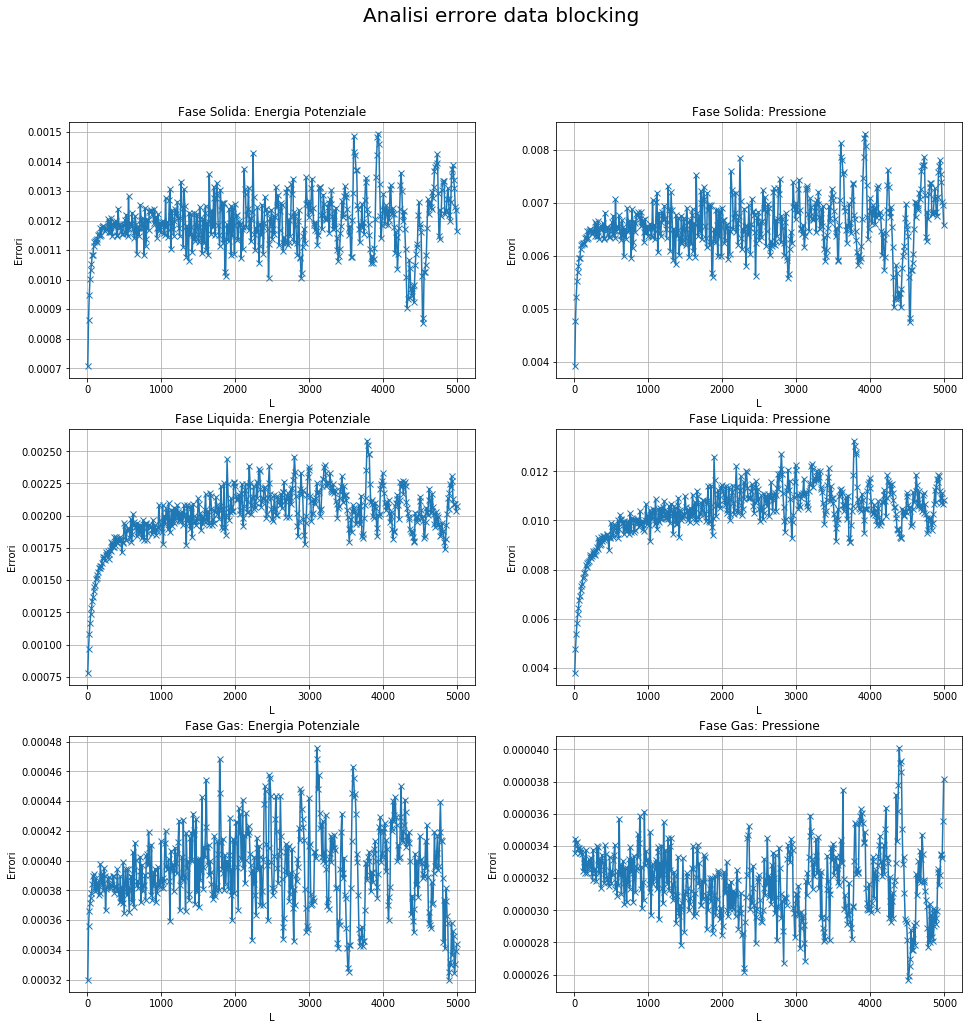

In [38]:
plt.figure(figsize=(16,16))
plt.suptitle('Analisi errore data blocking',fontsize=20)

plt.subplot(3,2,1)
plt.plot(L,err_epot_solid, marker='x')
plt.title('FASE SOLIDA: Energia Potenziale')
plt.xlabel('L')
plt.ylabel('Errori')
plt.grid(True)

plt.subplot(3,2,2)
plt.plot(L,err_pres_solid, marker='x')
plt.title('FASE SOLIDA: Pressione')
plt.xlabel('L')
plt.ylabel('Errori')
plt.grid(True)

plt.subplot(3,2,3)
plt.plot(L,err_epot_liquid, marker='x')
plt.title('FASE LIQUIDA: Energia Potenziale')
plt.xlabel('L')
plt.ylabel('Errori')
plt.grid(True)

plt.subplot(3,2,4)
plt.plot(L,err_pres_liquid, marker='x')
plt.title('FASE LIQUIDA: Pressione')
plt.xlabel('L')
plt.ylabel('Errori')
plt.grid(True)

plt.subplot(3,2,5)
plt.plot(L,err_epot_gas, marker='x')
plt.title('FASE GASSOSA: Energia Potenziale')
plt.xlabel('L')
plt.ylabel('Errori')
plt.grid(True)

plt.subplot(3,2,6)
plt.plot(L,err_pres_gas, marker='x')
plt.title('FASE GASSOSA: Pressione')
plt.xlabel('L')
plt.ylabel('Errori')
plt.grid(True)

plt.show()

### Exercise 07.2 - 07.3

Per risolvere questi esercizi, ho implementato il calcolo della funzione di distribuzione radiale $g(r)$ sia nel codice che simula l'*ensamble* NVT con il Metropolis sia in quello che simula NVE con l'algoritmo di Verlet.

### Exercise 07.4

#### Informazioni sulla simulazione NVE con algoritmo Verlet
Il codice adottato per simulare l'*ensamble* NVE con l'algoritmo Verlet è il medesimo adottato per svolgere l'esercizio <span style="color:red">"Exercise 04.4"</span>. Di conseguenza i parametri (temperatura di partenza, numero di passi algoritmo, numero di blocchi...) e i metodi di equilibrazione per tali simulazioni sono rimasti invariati (si veda dunque il *jupyter* di quell'esercitazione per ulteriori informazioni). Le uniche modifiche apportate riguardano il calcolo della $g(r)$ e in più sono state introdotte le correzioni di coda per l'energia potenziale e il viriale (e quindi la pressione).

#### Analisi dei risultati
Nelle celle sottostanti presento i risultati, in funzione del numero di blocchi $N_{block}$ (in unità SI) dei valori medi (con corrisponente errore) di $P$, $U/N$ ottenute dalle simulazioni di fase solida, liquida e gassosa per Argon e Krypton (le grandezze hanno il medesimo andamento funzionale ma riscalamenti diversi delle stesse grandezze adimensionate). Inoltre propongo gli andamenti delle $g(r)$ (per semplicità di lettura il raggio è espresso in unità di Lennard Jones $\sigma$) in funzione del raggio. Infine per completezza mostro un grafico delle temperature medie dei sistemi in funzione di $N_{block}$.
I risultati ottenuti per l'*ensamble* canonico e microcanonico sono posti a confronto. Si può osservare che:

- La funzione di distribuzione radiale $g(r)$ ottenuta per le tre fasi sembra essere ragionevole. La fase solida presenta ben visibili le shell di primi e secondi vicini (e altri picchi). La fase liquida e gassosa per grandi $r$ tendono a 1 poiché sono sistemi disordinati
- Se osservati solo attraverso le loro $g(r)$, l'*ensamble* canonico risulta essere indistinguibile da quello microcanonico.
- I risultati ottenuti per NVE rispetto a quelli dell'esercizio 04.4 risultano differenti poichè sono state introdotte le correzioni di coda. Questo mostra che tali correzioni non sono del tutto trascurabili.

Risultano ancora valide le osservazioni fatta per quanto riguarda i valori di pressione di fase solida, liquida e gassosa espresse nell'esercizio 04.4.


### Argon


Nella cella sottostante vengono inizializzate le unità di Lennard-Jones per l'Argon

In [22]:
Kb = 1.38E-23  #costante di boltzmann
sigma = 0.34*(10**(-9))   #unità di lunghezza in metri
e_Kb = 120.   #e/Kb     per la temperatura in kelvin
e = (e_Kb*Kb)   #energia in J
e_eV = e/(1.6*10**(-19))   #energia  in eV
p = e/(sigma**3)     #pressione in Pa 
p_atm = p/101325.  #pressione in atmosfere
m_au = 39.948
m = m_au*1.66054e-27   #Kg
t = sigma*np.sqrt(m/e)

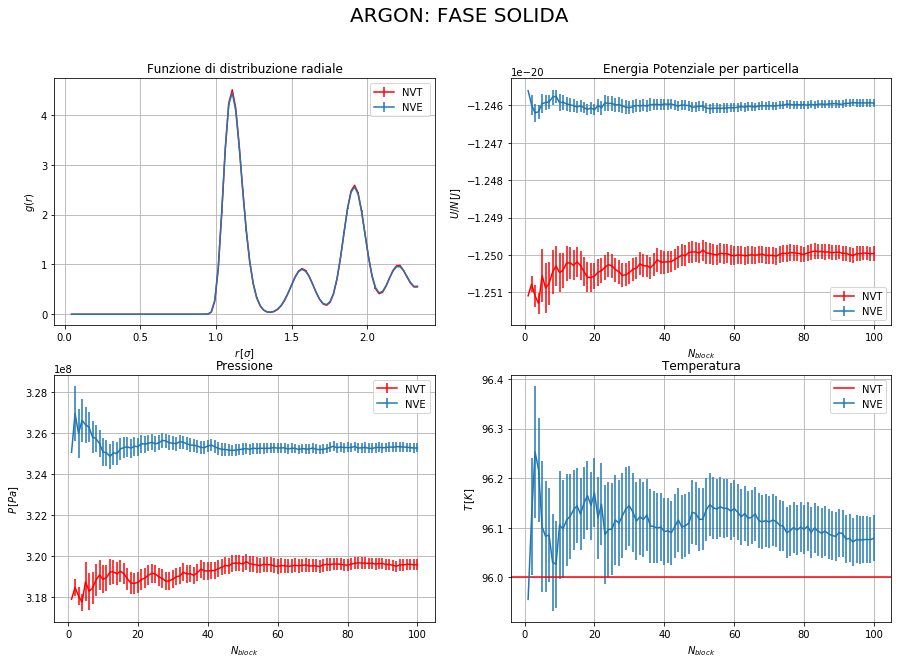

In [23]:
plt.figure(figsize=(15,10))
plt.suptitle('ARGON: FASE SOLIDA',fontsize=20)

plt.subplot(2,2,1)
r, gr, err_gr = np.loadtxt('Risultati/NVT_Metropolis/Solid/output.gave.0', usecols=(0,1,2),unpack='true')
plt.errorbar(r,gr, err_gr, color = 'red',label = 'NVT ')
r, gr, err_gr = np.loadtxt('Risultati/NVE_Verlet/Solid/output.gave.0', usecols=(0,1,2),unpack='true')
plt.errorbar(r,gr, err_gr,label = 'NVE')
plt.ylabel('$g(r)$')
plt.xlabel('$r \, [\sigma]$')
plt.grid(True)
plt.title('Funzione di distribuzione radiale')
plt.legend()

plt.subplot(2,2,2)
N, epot, err_epot = np.loadtxt('Risultati/NVT_Metropolis/Solid/output.epot.0', usecols=(0,1,2),unpack='true')
plt.errorbar(N,epot*e, err_epot*e,color = 'red',label = 'NVT')
N, epot, err_epot = np.loadtxt('Risultati/NVE_Verlet/Solid/output.epot.0', usecols=(0,1,2),unpack='true')
plt.errorbar(N,epot*e, err_epot*e,label = 'NVE')
plt.ylabel('$U/N \, [J]$')
plt.grid(True)
plt.xlabel('$N_{block}$')
plt.title('Energia Potenziale per particella')
plt.legend()

plt.subplot(2,2,3)
N, pres, err_pres = np.loadtxt('Risultati/NVT_Metropolis/Solid/output.pres.0', usecols=(0,1,2),unpack='true')
plt.errorbar(N,pres*p, err_pres*p, color = 'red',label = 'NVT')
N, pres, err_pres = np.loadtxt('Risultati/NVE_Verlet/Solid/output.pres.0', usecols=(0,1,2),unpack='true')
plt.errorbar(N,pres*p, err_pres*p,label = 'NVE')
plt.ylabel('$P \, [Pa]$')
plt.grid(True)
plt.xlabel('$N_{block}$')
plt.title('Pressione')
plt.legend()

plt.subplot(2,2,4)
N, temp, err_temp = np.loadtxt('Risultati/NVE_Verlet/Solid/output.temp.0', usecols=(0,1,2),unpack='true')
plt.errorbar(N,temp*e_Kb, err_temp*e_Kb,label = 'NVE')
plt.axhline(y=0.8*e_Kb, color = 'red',linestyle='-',label = 'NVT')
plt.ylabel('$T \, [K]$')
plt.grid(True)
plt.xlabel('$N_{block}$')
plt.title('Temperatura')
plt.legend()

plt.show()

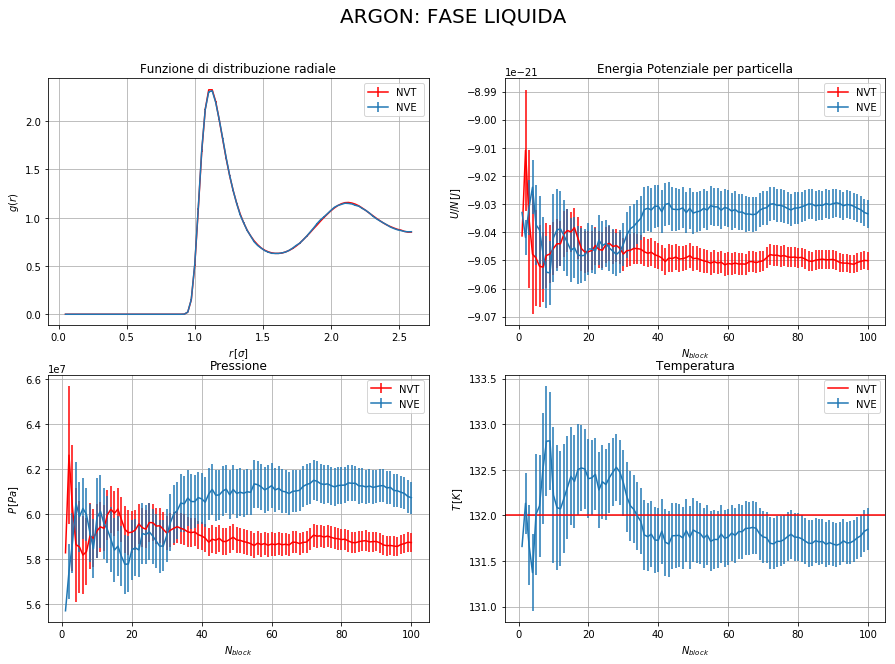

In [24]:
plt.figure(figsize=(15,10))
plt.suptitle('ARGON: FASE LIQUIDA',fontsize=20)

plt.subplot(2,2,1)
r, gr, err_gr = np.loadtxt('Risultati/NVT_Metropolis/Liquid/output.gave.0', usecols=(0,1,2),unpack='true')
plt.errorbar(r,gr, err_gr,color = 'red', label = 'NVT ')
r, gr, err_gr = np.loadtxt('Risultati/NVE_Verlet/Liquid/output.gave.0', usecols=(0,1,2),unpack='true')
plt.errorbar(r,gr, err_gr,label = 'NVE')
plt.ylabel('$g(r)$')
plt.grid(True)
plt.xlabel('$r \, [\sigma]$')
plt.title('Funzione di distribuzione radiale')
plt.legend()

plt.subplot(2,2,2)
N, epot, err_epot = np.loadtxt('Risultati/NVT_Metropolis/Liquid/output.epot.0', usecols=(0,1,2),unpack='true')
plt.errorbar(N,epot*e, err_epot*e,color = 'red',label = 'NVT')
N, epot, err_epot = np.loadtxt('Risultati/NVE_Verlet/Liquid/output.epot.0', usecols=(0,1,2),unpack='true')
plt.errorbar(N,epot*e, err_epot*e,label = 'NVE')
plt.ylabel('$U/N \, [J]$')
plt.grid(True)
plt.xlabel('$N_{block}$')
plt.title('Energia Potenziale per particella')
plt.legend()

plt.subplot(2,2,3)
N, pres, err_pres = np.loadtxt('Risultati/NVT_Metropolis/Liquid/output.pres.0', usecols=(0,1,2),unpack='true')
plt.errorbar(N,pres*p, err_pres*p,color = 'red',label = 'NVT')
N, pres, err_pres = np.loadtxt('Risultati/NVE_Verlet/Liquid/output.pres.0', usecols=(0,1,2),unpack='true')
plt.errorbar(N,pres*p, err_pres*p,label = 'NVE')
plt.ylabel('$P \, [Pa]$')
plt.grid(True)
plt.xlabel('$N_{block}$')
plt.title('Pressione')
plt.legend()

plt.subplot(2,2,4)
N, temp, err_temp = np.loadtxt('Risultati/NVE_Verlet/Liquid/output.temp.0', usecols=(0,1,2),unpack='true')
plt.errorbar(N,temp*e_Kb, err_temp*e_Kb,label = 'NVE')
plt.axhline(y=1.1*e_Kb,color = 'red', linestyle='-',label = 'NVT')
plt.ylabel('$T \, [K]$')
plt.grid(True)
plt.xlabel('$N_{block}$')
plt.title('Temperatura')
plt.legend()

plt.show()

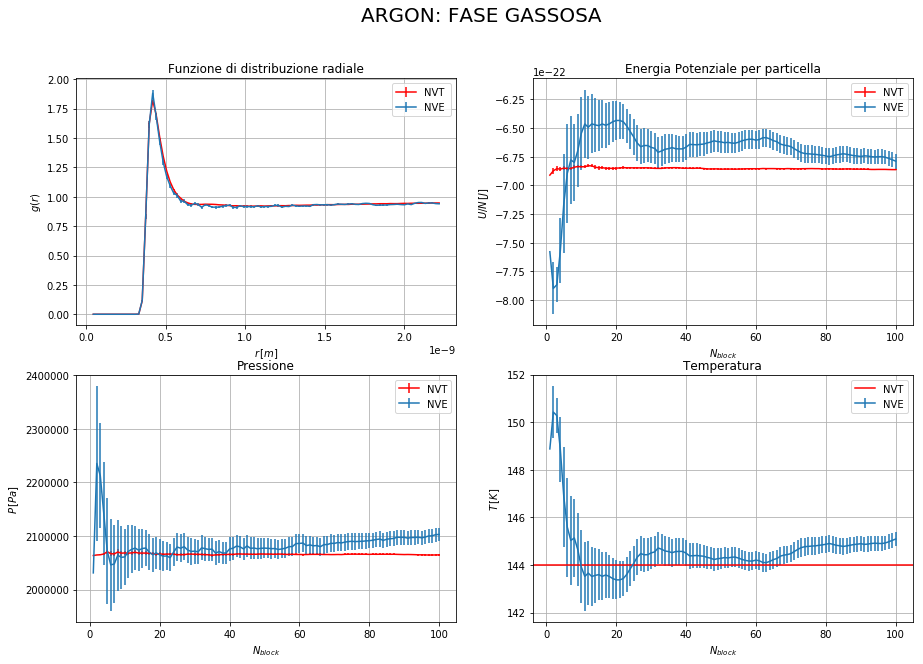

In [25]:
plt.figure(figsize=(15,10))
plt.suptitle('ARGON: FASE GASSOSA',fontsize=20)

plt.subplot(2,2,1)
r, gr, err_gr = np.loadtxt('Risultati/NVT_Metropolis/Gas/output.gave.0', usecols=(0,1,2),unpack='true')
plt.errorbar(r*sigma,gr, err_gr, color = 'red',label = 'NVT ')
r, gr, err_gr = np.loadtxt('Risultati/NVE_Verlet/Gas/output.gave.0', usecols=(0,1,2),unpack='true')
plt.errorbar(r*sigma,gr, err_gr,label = 'NVE')
plt.ylabel('$g(r) $')
plt.xlabel('$r \, [m]$')
plt.grid(True)
plt.title('Funzione di distribuzione radiale')
plt.legend()

plt.subplot(2,2,2)
N, epot, err_epot = np.loadtxt('Risultati/NVT_Metropolis/Gas/output.epot.0', usecols=(0,1,2),unpack='true')
plt.errorbar(N,epot*e, err_epot*e,color = 'red',label = 'NVT')
N, epot, err_epot = np.loadtxt('Risultati/NVE_Verlet/Gas/output.epot.0', usecols=(0,1,2),unpack='true')
plt.errorbar(N,epot*e, err_epot*e,label = 'NVE')
plt.ylabel('$U/N \, [J]$')
plt.xlabel('$N_{block}$')
plt.grid(True)
plt.title('Energia Potenziale per particella')
plt.legend()

plt.subplot(2,2,3)
N, pres, err_pres = np.loadtxt('Risultati/NVT_Metropolis/Gas/output.pres.0', usecols=(0,1,2),unpack='true')
plt.errorbar(N,pres*p, err_pres*p,color = 'red',label = 'NVT')
N, pres, err_pres = np.loadtxt('Risultati/NVE_Verlet/Gas/output.pres.0', usecols=(0,1,2),unpack='true')
plt.errorbar(N,pres*p, err_pres*p,label = 'NVE')
plt.ylabel('$P \, [Pa]$')
plt.xlabel('$N_{block}$')
plt.grid(True)
plt.title('Pressione')
plt.legend()

plt.subplot(2,2,4)
N, temp, err_temp = np.loadtxt('Risultati/NVE_Verlet/Gas/output.temp.0', usecols=(0,1,2),unpack='true')
plt.errorbar(N,temp*e_Kb, err_temp*e_Kb,label = 'NVE')
plt.axhline(y=1.2*e_Kb, linestyle='-',color = 'red',label = 'NVT')
plt.ylabel('$T \, [K]$')
plt.grid(True)
plt.xlabel('$N_{block}$')
plt.title('Temperatura')
plt.legend()

plt.show()

### Krypton

Nella cella sottostante vengono inizializzate le unità di Lennard-Jones per il Krypton

In [26]:
Kb = 1.38E-23   #costante di boltzmann
sigma = 0.364*(10**(-9))   # per lunghezza in metri
e_Kb = 164.   #e/Kb     for temperatura in K
e = (e_Kb*Kb)   #energia in J
e_eV = e/(1.6*10**(-19))   #energia in eV
p = e/(sigma**3)     #pressione in Pa 
p_atm = p/101325.   #pressione in atmosfere
m_au = 83.798
m = m_au*1.66054e-27   #Kg
t = sigma*np.sqrt(m/e)

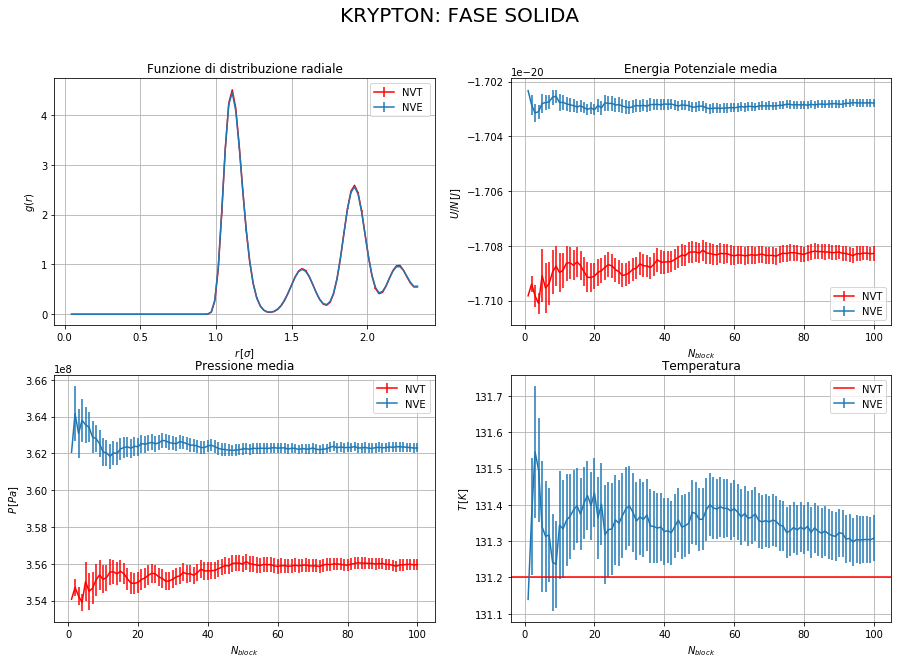

In [27]:
plt.figure(figsize=(15,10))
plt.suptitle('KRYPTON: FASE SOLIDA',fontsize=20)

plt.subplot(2,2,1)
r, gr, err_gr = np.loadtxt('Risultati/NVT_Metropolis/Solid/output.gave.0', usecols=(0,1,2),unpack='true')
plt.errorbar(r,gr, err_gr, color = 'red',label = 'NVT ')
r, gr, err_gr = np.loadtxt('Risultati/NVE_Verlet/Solid/output.gave.0', usecols=(0,1,2),unpack='true')
plt.errorbar(r,gr, err_gr,label = 'NVE')
plt.ylabel('$g(r)$')
plt.xlabel('$r \, [\sigma]$')
plt.grid(True)
plt.title('Funzione di distribuzione radiale')
plt.legend()

plt.subplot(2,2,2)
N, epot, err_epot = np.loadtxt('Risultati/NVT_Metropolis/Solid/output.epot.0', usecols=(0,1,2),unpack='true')
plt.errorbar(N,epot*e, err_epot*e,color = 'red',label = 'NVT')
N, epot, err_epot = np.loadtxt('Risultati/NVE_Verlet/Solid/output.epot.0', usecols=(0,1,2),unpack='true')
plt.errorbar(N,epot*e, err_epot*e,label = 'NVE')
plt.ylabel('$U/N \, [J]$')
plt.xlabel('$N_{block}$')
plt.grid(True)
plt.title('Energia Potenziale media')
plt.legend()

plt.subplot(2,2,3)
N, pres, err_pres = np.loadtxt('Risultati/NVT_Metropolis/Solid/output.pres.0', usecols=(0,1,2),unpack='true')
plt.errorbar(N,pres*p, err_pres*p,color = 'red',label = 'NVT')
N, pres, err_pres = np.loadtxt('Risultati/NVE_Verlet/Solid/output.pres.0', usecols=(0,1,2),unpack='true')
plt.errorbar(N,pres*p, err_pres*p,label = 'NVE')
plt.ylabel('$P \, [Pa]$')
plt.xlabel('$N_{block}$')
plt.grid(True)
plt.title('Pressione media')
plt.legend()

plt.subplot(2,2,4)
N, temp, err_temp = np.loadtxt('Risultati/NVE_Verlet/Solid/output.temp.0', usecols=(0,1,2),unpack='true')
plt.errorbar(N,temp*e_Kb, err_temp*e_Kb,label = 'NVE')
plt.axhline(y=0.8*e_Kb, linestyle='-',color = 'red',label = 'NVT')
plt.ylabel('$T \, [K]$')
plt.grid(True)
plt.xlabel('$N_{block}$')
plt.title('Temperatura')
plt.legend()

plt.show()

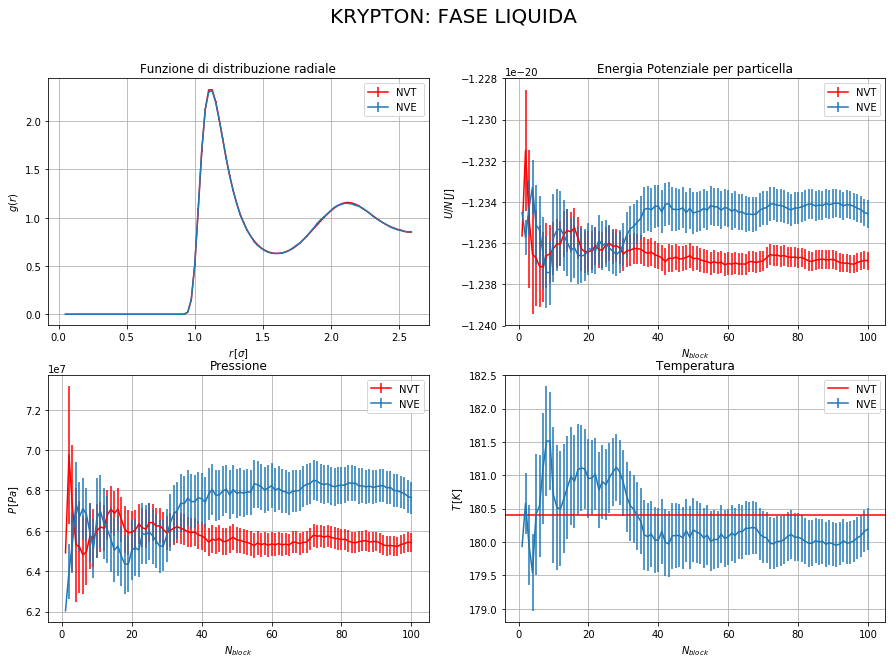

In [28]:
plt.figure(figsize=(15,10))
plt.suptitle('KRYPTON: FASE LIQUIDA',fontsize=20)

plt.subplot(2,2,1)
r, gr, err_gr = np.loadtxt('Risultati/NVT_Metropolis/Liquid/output.gave.0', usecols=(0,1,2),unpack='true')
plt.errorbar(r,gr, err_gr,color = 'red', label = 'NVT ')
r, gr, err_gr = np.loadtxt('Risultati/NVE_Verlet/Liquid/output.gave.0', usecols=(0,1,2),unpack='true')
plt.errorbar(r,gr, err_gr,label = 'NVE')
plt.ylabel('$g(r)$')
plt.xlabel('$r \, [\sigma]$')
plt.grid(True)
plt.title('Funzione di distribuzione radiale')
plt.legend()

plt.subplot(2,2,2)
N, epot, err_epot = np.loadtxt('Risultati/NVT_Metropolis/Liquid/output.epot.0', usecols=(0,1,2),unpack='true')
plt.errorbar(N,epot*e, err_epot*e,color = 'red',label = 'NVT')
N, epot, err_epot = np.loadtxt('Risultati/NVE_Verlet/Liquid/output.epot.0', usecols=(0,1,2),unpack='true')
plt.errorbar(N,epot*e, err_epot*e,label = 'NVE')
plt.ylabel('$U/N \, [J]$')
plt.xlabel('$N_{block}$')
plt.grid(True)
plt.title('Energia Potenziale per particella')
plt.legend()

plt.subplot(2,2,3)
N, pres, err_pres = np.loadtxt('Risultati/NVT_Metropolis/Liquid/output.pres.0', usecols=(0,1,2),unpack='true')
plt.errorbar(N,pres*p, err_pres*p,color = 'red',label = 'NVT')
N, pres, err_pres = np.loadtxt('Risultati/NVE_Verlet/Liquid/output.pres.0', usecols=(0,1,2),unpack='true')
plt.errorbar(N,pres*p, err_pres*p,label = 'NVE')
plt.ylabel('$P \, [Pa]$')
plt.xlabel('$N_{block}$')
plt.grid(True)
plt.title('Pressione')
plt.legend()

plt.subplot(2,2,4)
N, temp, err_temp = np.loadtxt('Risultati/NVE_Verlet/Liquid/output.temp.0', usecols=(0,1,2),unpack='true')
plt.errorbar(N,temp*e_Kb, err_temp*e_Kb,label = 'NVE')
plt.axhline(y=1.1*e_Kb, linestyle='-',color = 'red',label = 'NVT')
plt.ylabel('$T \, [K]$')
plt.grid(True)
plt.xlabel('$N_{block}$')
plt.title('Temperatura')
plt.legend()

plt.show()

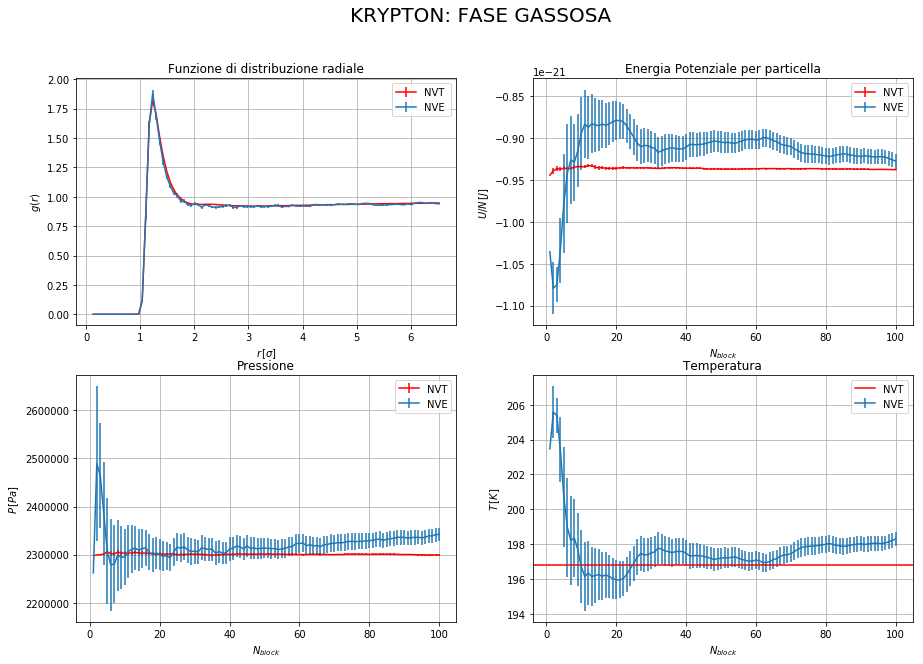

In [29]:
plt.figure(figsize=(15,10))
plt.suptitle('KRYPTON: FASE GASSOSA',fontsize=20)

plt.subplot(2,2,1)
r, gr, err_gr = np.loadtxt('Risultati/NVT_Metropolis/Gas/output.gave.0', usecols=(0,1,2),unpack='true')
plt.errorbar(r,gr, err_gr, color = 'red',label = 'NVT ')
r, gr, err_gr = np.loadtxt('Risultati/NVE_Verlet/Gas/output.gave.0', usecols=(0,1,2),unpack='true')
plt.errorbar(r,gr, err_gr,label = 'NVE')
plt.ylabel('$g(r) $')
plt.xlabel('$r \, [\sigma]$')
plt.grid(True)
plt.title('Funzione di distribuzione radiale')
plt.legend()

plt.subplot(2,2,2)
N, epot, err_epot = np.loadtxt('Risultati/NVT_Metropolis/Gas/output.epot.0', usecols=(0,1,2),unpack='true')
plt.errorbar(N,epot*e, err_epot*e,color = 'red',label = 'NVT')
N, epot, err_epot = np.loadtxt('Risultati/NVE_Verlet/Gas/output.epot.0', usecols=(0,1,2),unpack='true')
plt.errorbar(N,epot*e, err_epot*e,label = 'NVE')
plt.ylabel('$U/N \, [J]$')
plt.xlabel('$N_{block}$')
plt.grid(True)
plt.title('Energia Potenziale per particella')
plt.legend()

plt.subplot(2,2,3)
N, pres, err_pres = np.loadtxt('Risultati/NVT_Metropolis/Gas/output.pres.0', usecols=(0,1,2),unpack='true')
plt.errorbar(N,pres*p, err_pres*p,color = 'red',label = 'NVT')
N, pres, err_pres = np.loadtxt('Risultati/NVE_Verlet/Gas/output.pres.0', usecols=(0,1,2),unpack='true')
plt.errorbar(N,pres*p, err_pres*p,label = 'NVE')
plt.ylabel('$P \, [Pa]$')
plt.xlabel('$N_{block}$')
plt.grid(True)
plt.title('Pressione')
plt.legend()

plt.subplot(2,2,4)
N, temp, err_temp = np.loadtxt('Risultati/NVE_Verlet/Gas/output.temp.0', usecols=(0,1,2),unpack='true')
plt.errorbar(N,temp*e_Kb, err_temp*e_Kb,label = 'NVE')
plt.axhline(y=1.2*e_Kb, linestyle='-',color = 'red',label = 'NVT')
plt.ylabel('$T \, [K]$')
plt.grid(True)
plt.xlabel('$N_{block}$')
plt.title('Temperatura')
plt.legend()

plt.show()